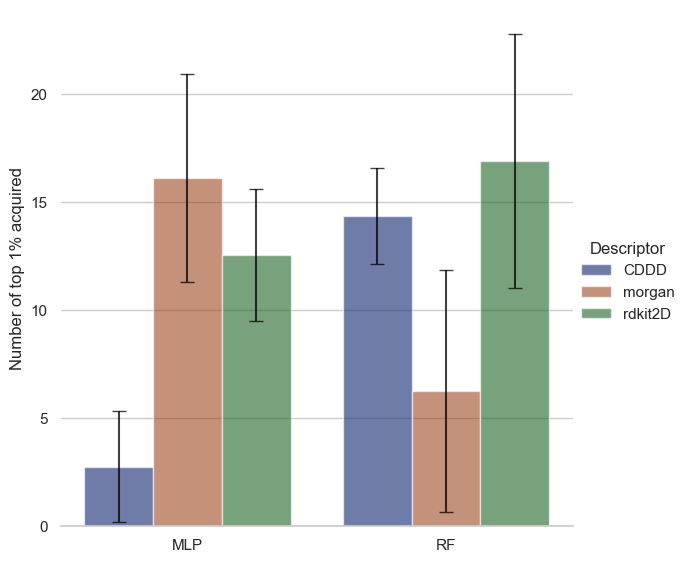

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob

def get_data(files):
    data_list = {}
    for file in files:
        data = pd.read_csv(file)
        columns_after_rank = data.columns[3:]
        name = file.split('\\')[-1].split('.')[0]
        for column in columns_after_rank:
            data[column] *= 100
            pivot_data = data.pivot(index='rank', columns='replicate', values=column)
            pivot_data['Avg.'] = pivot_data.mean(axis=1)
            pivot_data['Std. dev.'] = pivot_data.std(axis=1)
            data_list[name] = pivot_data
    return data_list

def transform_data(data_dict):
    avg_list = []
    std_list = []
    model_list = []
    descriptor_list = []
    
    for name, df in data_dict.items():
        last_record = df.iloc[-1]
        avg_list.append(last_record['Avg.'])
        std_list.append(last_record['Std. dev.'])
        
        parts = name.split(' ')
        model_list.append(parts[0])
        descriptor_list.append(' '.join(parts[1:]))
        
    result_df = pd.DataFrame({
        'Avg': avg_list,
        'Std': std_list,
        'Model': model_list,
        'Descriptor': descriptor_list
    })
    
    return result_df

files = glob.glob('**/*.csv', recursive=True)
data = get_data(files)
transformed_data = transform_data(data)

sns.set_theme(style="whitegrid")

# Create the bar plot
p = sns.catplot(data=transformed_data, kind="bar", x="Model", y="Avg", hue="Descriptor",
                palette="dark", alpha=.6, height=6)

# Error bars addition, corrected
for i, patch in enumerate(p.ax.patches):
    # The index `i` relates directly to the DataFrame's index if sorted similarly
    bar_width = patch.get_width()
    bar_x = patch.get_x()
    bar_center = bar_x + bar_width / 2
    avg = patch.get_height()

    # Ensure index is valid
    if i < len(transformed_data):
        std = transformed_data.iloc[i]['Std']
        plt.errorbar(bar_center, avg, yerr=std, fmt='none', ecolor='black', capsize=5, alpha=0.75)

p.despine(left=True)
p.set_axis_labels("", "Number of top 1% acquired")
p.legend.set_title("Descriptor")
p.ax.set_ylim(bottom=0)
plt.show()